## **TP2: Métodos** 

In [ ]:
import numpy as np
import matplotlib as plt
import numpy.linalg as lng
from scipy.linalg import lu
from scipy import linalg
import networkx as nx

Leer grafos

In [ ]:
def leer_grafo(path):
    file = open(path,'r')
    n = int(file.readline())
    m = int(file.readline())
    M = np.zeros((n, n))
    i = 0
    with open(path,'r') as file:
    # reading each line    
        for line in file:
            if(i>1):
                a = int(line.split()[0])
                b = int(line.split()[1])
                M[a-1][b-1] = 1
            i+=1
    return M

In [ ]:
def leer_karateclub(path = "drive/MyDrive/Colab Notebooks/tp2/karateclub_matriz.txt"):
  M = np.zeros(34*34).reshape(34, 34)
  with open(path,'r') as file:
    # reading each line 
    i = 0
    for line in file:
      line = line.split()
      for j in range(0, len(line)):

        M[i][j] = line[j]
      i+=1
  return M

In [ ]:
M = leer_karateclub()
import sys 
np.set_printoptions(threshold=sys.maxsize)
np.sum(M)


156.0

In [ ]:
def leer_facebook(path = "drive/MyDrive/Colab Notebooks/tp2/ego-facebook.edges"):
  maxInd = 0
  m = 0
  with open(path,'r') as file:
    # reading each line 
    for line in file:
      line = line.split()
      m+=1
      for j in range(0, len(line)):
        maxInd = max(maxInd, int(line[j]))
  return [maxInd, m]

In [ ]:
maxInd,m = leer_facebook()
m

28048

Leer karate club con NetworkX

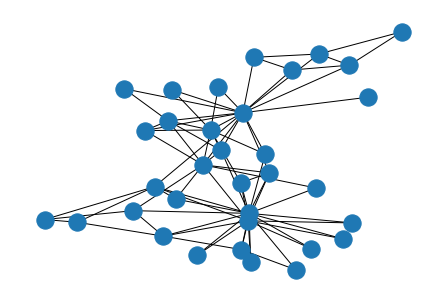

In [ ]:
karate = nx.karate_club_graph()

In [ ]:
facebook = nx.ego_graph(G, ego)

# Centralidad del vector 

In [ ]:
A = leer_karateclub()

In [ ]:
linalg.eig(A)

(array([ 6.72569773e+00+0.00000000e+00j,  4.97707423e+00+0.00000000e+00j,
        -4.48722919e+00+0.00000000e+00j, -3.44793486e+00+0.00000000e+00j,
        -3.11069092e+00+0.00000000e+00j,  2.91650670e+00+0.00000000e+00j,
        -2.43742443e+00+0.00000000e+00j,  2.30908767e+00+0.00000000e+00j,
        -2.09082295e+00+0.00000000e+00j, -1.68768945e+00+0.00000000e+00j,
        -1.44407374e+00+0.00000000e+00j, -1.19242425e+00+0.00000000e+00j,
        -1.04208785e+00+0.00000000e+00j, -7.92406815e-01+0.00000000e+00j,
        -4.18818748e-01+0.00000000e+00j,  1.48615954e+00+0.00000000e+00j,
         1.45305566e+00+0.00000000e+00j,  1.08328639e+00+0.00000000e+00j,
         1.03145042e+00+0.00000000e+00j,  8.34304102e-01+0.00000000e+00j,
         2.99410685e-01+0.00000000e+00j,  4.19729474e-01+0.00000000e+00j,
         6.15840589e-01+0.00000000e+00j, -2.00000000e+00+0.00000000e+00j,
        -1.84096457e-16+0.00000000e+00j,  3.25975263e-16+0.00000000e+00j,
         1.19978798e-16+1.01484071e-16